## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#import and view data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
#find number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique() #number of unique users

290584

d. The proportion of users converted.

In [5]:
#percentage of converted users
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#count rows for each case of misalignment
misaligned = df.query('group == "treatment" & landing_page != "new_page" or group != "treatment" & landing_page == "new_page"')
misaligned.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum() # count null values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#create new dataframe without misaligned values
df2 = df.query('group == "treatment" & landing_page == "new_page" or group == "control" & landing_page == "old_page"')
df2.shape

(290585, 5)

In [49]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [50]:
df2.user_id.nunique() #number of unique users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [51]:
df2[df2.duplicated(['user_id'], keep=False)] #duplicated user

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page


c. What is the row information for the repeat **user_id**? 

In [12]:
#the duplicated rows are 1899 and 2893, as seen above

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#drop the row with the duplicate id
df2.drop([2893], inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
#take mean of converted column
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [52]:
control_mean = df2.query('group == "control"')['converted'].mean() #probability a person in the control group converted
control_mean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [53]:
treatment_mean = df2.query('group == "treatment"')['converted'].mean() #probability a person in the treatment group converted
treatment_mean

0.11880806551510564

d. What is the probability that an individual received the new page?

In [54]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0] # users who recieved new page divided by number of users

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**It appears that the probability of conversion was higher with the original landing page, but the values are very close, and further analysis is needed to determine whether or not these results are statistically significant.  A difference of less than 1% is not practically significant.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0 : p_{old} - p_{new} \geq 0$$
$$H_1 : p_{old} - p_{new} < 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
#find the size of the old and new pages and then create samples
size_old = df2.query('landing_page == "old_page"').shape[0]
size_new = df2.query('landing_page == "new_page"').shape[0]
sample_old = df.sample(size_old)
sample_new = df.sample(size_new)
sample_new['converted'].mean()

0.11869107425504094

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
sample_old['converted'].mean() #conversion rate for old page under null

0.11978055261092832

c. What is $n_{new}$?

In [57]:
#call size_new
size_new

145310

d. What is $n_{old}$?

In [56]:
#call size_old
size_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#bootstrap sample with size equal to number of new pages
new_page_converted = df2['converted'].sample(size_new, replace=True)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
#bootstrap sample with size equal to number of new pages
old_page_converted = df2['converted'].sample(size_old, replace=True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [55]:
new_page_converted.mean() - old_page_converted.mean() # find difference in means

0.001099084526329161

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [58]:
#loop through 10,000 simualtions and take the difference
p_diffs = [] 
for _ in range(10000):
    new_page_converted = df2['converted'].sample(size_new, replace=True)
    old_page_converted = df2['converted'].sample(size_old, replace=True)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

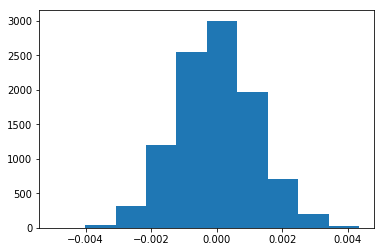

In [59]:
plt.hist(p_diffs); #plot the results in a histogram

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [60]:
(p_diffs > (treatment_mean - control_mean)).mean() #calculate proportion of values in p_diffs greater than the actual statistic

0.90190000000000003

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part J, I calculated the p-value, which is the proportion of values that could be found within the null hypothesis. In this case, more than 90% of the values in the null were greater than the statistic, which is no where near the error threshold of 5% needed to disprove the null hypithesis. More simply put, there is no statiscal evidence to say that either page performs better than the other.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [61]:
import statsmodels.api as sm

#collect sizes of new and old pages, and converts for each
convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [62]:
#run z-test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value=None, alternative='two-sided', prop_var=False)
print(z_score, p_value)

1.31092419842 0.189883374482


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value given above is still past the error threshold of 5% and thus does not reject the null hypothesis, same as in parts j and k**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we are dealing with a categorical response variable, we need to perform a logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [63]:
#add intercept and get dummy variables for new_page
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [65]:
# run a logistic regression for ab_page
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [64]:
result.summary() #show results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        17:52:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The hypotheses are the same, that there is no effect for the null, and that there is an effect for the alternative. There is not much of a diference between the p-values. I got around 19% for both. the original one I calculated in part 2 was around 90%, which is much higher. this may different because I was using actual data instead of a bootstrap sample.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is good to see if other factors affect the outcome more than others. However, if the variable are strongly correlated to each other, there is a higher risk of multi-colinearity with each added dependent variable.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [67]:
# import countries data and join to df2, then get dummies for countries
countries = pd.read_csv('countries.csv')
df3 = df2.join(countries.set_index('user_id'), on='user_id')
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

# run logistic regression on countries
log_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])
result2 = log_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Dec 2018   Pseudo R-squ.:               1.521e-05
Time:                        17:54:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [68]:
#exponentiate the coefficients
np.exp(-.0408), np.exp(0.0099)

(0.96002111497165088, 1.0099491671175422)

**It appears that Canadian and UK users are just as likely to convert as are US users, holding all esle constant. The p-values also do not meet the error threshold, so the null holds.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [69]:
#run new regression with country and page
log_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK', 'ab_page']])
result3 = log_mod3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Dec 2018   Pseudo R-squ.:               2.323e-05
Time:                        17:55:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

In [71]:
#exponentiate coefficients
np.exp(-0.0408), np.exp(0.0099), np.exp(-0.0149)

(0.96002111497165088, 1.0099491671175422, 0.9852104557227469)

**It appears that all variabel show no significant effect on conversion vs. teh baseline of a control user from the US. the p-values are beyond the error threshold, and the exponentiated coefficients are all near 1. The null hypothesis cannot be rejected.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [72]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0